<a href="https://colab.research.google.com/github/DL4DS/sp2024_notebooks/blob/main/discussion/02_intro_nn_training.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disc3

Goal:
* Intro to Model Training in Pytorch (image classification, text classification)

In [1]:
# installs
!pip install --upgrade pip
!pip install -U torchsummary
!pip install seaborn
!pip install tabulate

In [2]:
# imports
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torchsummary import summary
from PIL import Image
import torchvision.transforms.functional as F
from copy import deepcopy
import seaborn as sns
from tabulate import tabulate
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import numpy as np
import nltk
nltk.download("all")

/Users/xavierohan/anaconda3/envs/dl4ds/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/xavierohan/anaconda3/envs/dl4ds/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2ACC9186-30B9-352C-9670-84BB544BCD8F> /Users/xavierohan/anaconda3/envs/dl4ds/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <ADC0A61A-5B83-3A02-975F-EE5DFF441305> /Users/xavierohan/anaconda3/envs/dl4ds/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/xavierohan/anaconda3/envs/dl4ds/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._r

True

---

# Loss Functions

Divided it into mainly two:
1. Regression Loss Functions - Used when the model is predicting a continuous value, like the price of a house or a person's age.
2. Classification Loss Functions - Used when the model is predicting a discrete value, like whether an email is spam or not, or whether an image contains a cat or a dog.



## Regression Problems

### Mean Absolute Error (MAE)

``nn.L1Loss``

- Also called L1 loss.
- Computes the ``magnitude`` of the error, without considering the direction (positive or negative) of the error.    
- If abs() was not used, the positive and negative errors could cancel each other out.

Where it's useful:    
 - Regression problems, especially when there are outliers (points that are far away from the rest of the data). MAE is considered to be robust to outliers.

### Mean Squared Error (MSE)

``nn.MSELoss()``

- Also called L2 loss.
- Computes the average of the ``squared differences`` between the actual and predicted values.
- The squaring implies that larger mistakes result in much larger errors than smaller mistakes, giving more weight to larger errors. (if the classifier was off by 100, the error would be 10,000, but if it was off by 0.1, the error would be 0.01). Thereby, L2 loss punishes the model for making large errors more severely than MAE.

Where it's useful:

- Regression Problems

### MAE vs MSE

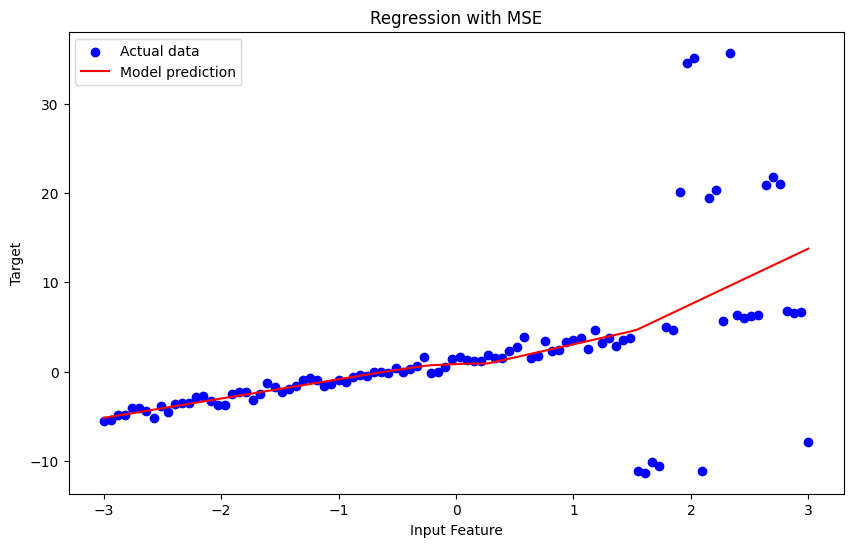

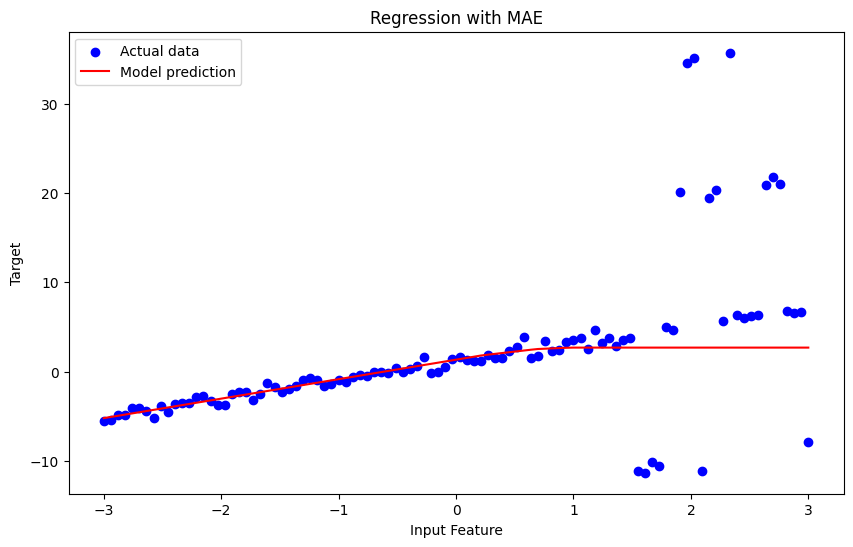

In [48]:
import torch
import torch.nn as nn
import torch.optim
import matplotlib.pyplot as plt


torch.manual_seed(0)  # Set seed for reproducibility

# Generate a 1D input dataset
ip = torch.linspace(-3, 3, 100).view(-1, 1)  # Evenly spaced points in 1D
a, b = 2, 1  # Linear relationship parameters
target = a * ip + b + torch.randn(ip.size()) * 0.5  # Adding some noise

# Introduce outliers
num_outliers = 20
outliers_indices = torch.randint(75, 100, (num_outliers,))  # Choose outliers towards one end
for i in outliers_indices:
    target[i] += 15 * torch.sign(torch.randn(1))  # Significantly offset outliers individually

# Define the LinearRegression model class
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.hidden = nn.Linear(input_dim, 5)
        self.linear = nn.Linear(5, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.linear(x)

# Adjusted function for 1D input
def train_and_plot(model, criterion, optimizer, ip, target, title):
    for epoch in range(1000):  # More iterations for a clearer difference
        outputs = model(ip)
        loss = criterion(outputs, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(ip.numpy(), target.numpy(), color='blue', label='Actual data')
    with torch.no_grad():
        ip_range = torch.linspace(ip.min(), ip.max(), 100).view(-1, 1)
        predicted = model(ip_range).numpy()
        plt.plot(ip_range.numpy(), predicted, color='red', label='Model prediction')
    plt.title(title)
    plt.xlabel('Input Feature')
    plt.ylabel('Target')
    plt.legend()
    plt.show()

input_dim = 1
output_dim = 1

# Train and plot with MSE
model_mse = LinearRegression(input_dim, output_dim)
optimizer_mse = torch.optim.SGD(model_mse.parameters(), lr=0.01)
mse_loss = nn.MSELoss()
train_and_plot(model_mse, mse_loss, optimizer_mse, ip, target, 'Regression with MSE')

# Train and plot with MAE
model_mae = LinearRegression(input_dim, output_dim)
optimizer_mae = torch.optim.SGD(model_mae.parameters(), lr=0.01)
mae_loss = nn.L1Loss()
train_and_plot(model_mae, mae_loss, optimizer_mae, ip, target, 'Regression with MAE')


Note:

For both L1 and L2 loss, you can pass in the reduction method (none, sum, mean) as an argument to the loss function. The default is mean.

## Classification Problems

### Binary Classification

#### Binary Cross Entropy Loss

``nn.BCELoss()``
* Used when there are only two classes.
* Output of the model is usually a Sigmoid Layer, that squashes the output between 0 and 1.
* Target is 

Alternative: ``nn.BCEWithLogitsLoss()`` - Combines a Sigmoid layer and the BCELoss in one single class.

In [4]:
from torch import nn
criterion = nn.BCELoss()


input = torch.tensor([[-1.2, 3.7, 8.0]], dtype=torch.float)
sigmoid_output = nn.functional.sigmoid(input)
target_1 = torch.tensor([[1, 0, 0]], dtype=torch.float)
loss_1 = criterion(sigmoid_output, target_1)
print(f"input: {input}, sigmoid_output: {sigmoid_output}, target: {target_1}, loss: {loss_1}")

target_2 = torch.tensor([[0, 1, 1]], dtype=torch.float)  # Example of a different target
sigmoid_output = nn.functional.sigmoid(input)
loss_2 = criterion(sigmoid_output, target_2)
print(f"input: {input}, sigmoid_output: {sigmoid_output}, target: {target_2}, loss: {loss_2}")

input: tensor([[-1.2000,  3.7000,  8.0000]]), sigmoid_output: tensor([[0.2315, 0.9759, 0.9997]]), target: tensor([[1., 0., 0.]]), loss: 4.3960280418396
input: tensor([[-1.2000,  3.7000,  8.0000]]), sigmoid_output: tensor([[0.2315, 0.9759, 0.9997]]), target: tensor([[0., 1., 1.]]), loss: 0.09601356834173203


### Multi-Class Classification

#### Cross Entropy Loss

``nn.CrossEntropyLoss()``

- Used for multi-class classification problems.
- Expects raw scores (logits) for each class as input, and applies the softmax function internally to convert the scores into probabilities.


In [5]:
from torch import nn
criterion = nn.CrossEntropyLoss()
input = torch.tensor([[3.2, 1.3,0.2, 0.8]],dtype=torch.float)

target_1 = torch.tensor([3], dtype=torch.long)
print(f"input: {input}, target: {target_1}, loss: {criterion(input, target_1)}")

target_2 = torch.tensor([0], dtype=torch.long)
print(f"input: {input}, target: {target_2}, loss: {criterion(input, target_2)}")

input: tensor([[3.2000, 1.3000, 0.2000, 0.8000]]), target: tensor([3]), loss: 2.6546993255615234
input: tensor([[3.2000, 1.3000, 0.2000, 0.8000]]), target: tensor([0]), loss: 0.2546992003917694


In [6]:
input = torch.tensor([[3.2, 1.3,0.2, 8.0]],dtype=torch.float)
target = torch.tensor([3], dtype=torch.long)

print(f"input: {input}, target: {target}, loss: {criterion(input, target)}")

input: tensor([[3.2000, 1.3000, 0.2000, 8.0000]]), target: tensor([3]), loss: 0.009822015650570393


Note: The input to the loss function is expected to contain raw, unnormalized scores for each class. The target is the class label.

### What is a good cross-entropy score?

- Cross-Entropy = 0.00: Perfect probabilities.
- Cross-Entropy < 0.02: Great probabilities.
- Cross-Entropy < 0.05: On the right track.
- Cross-Entropy < 0.20: Fine.
- Cross-Entropy > 0.30: Not great.
- Cross-Entropy > 1.00: Terrible.
- Cross-Entropy > 2.00 Something is broken.

Ref: https://machinelearningmastery.com/cross-entropy-for-machine-learning/

## Small Note on Activation Functions

Wether or not you use a activation function in the last layer depends on the loss function you are using and the problem setting. For example, if you are using BCELoss, you should use a Sigmoid activation function in the last layer. If you are using CrossEntropyLoss, you do not have to pass the outputs through any activation function. Same for when your task is regression, you do not have to pass the outputs through any activation function.

---

### Helper Functions

In [7]:
# Helper functions

def view_classify(img, logits):
    ''' Function for viewing an image and its predicted classes.
    '''
    ps = nn.functional.softmax(logits, dim=1).data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    # Ensure the image is displayed in grayscale
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()


def calculate_metrics(model, loss_fn, data_loader, flatten=False):
    # Ensure the model is in evaluation mode
    model.eval()
    
    correct = 0
    total = 0
    running_loss = 0

    # No need to track gradients for validation, thus wrap in torch.no_grad()
    with torch.no_grad():
        for images, labels in data_loader:
            # If your model expects the input images to be flattened, uncomment the following line
            if flatten:
                images = images.view(images.shape[0], -1)
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Get the index of the max log-probability as the predicted label
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

    accuracy = 100 * correct / total
    loss = running_loss / len(data_loader)
    return accuracy, loss

def tabulate_results(results):
    model_names = list(results.keys())
    metrics = list(results[model_names[0]].keys())
    table = []
    for model_name in model_names:
        row = [model_name]
        for metric in metrics:
            row.append(results[model_name][metric])
        table.append(row)
    print(tabulate(table, headers=["Model"] + metrics, tablefmt="pretty"))


class PerformanceTracker:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
    
    def update_train(self, loss, accuracy):
        self.train_losses.append(loss)
        self.train_accuracies.append(accuracy)
    
    def update_val(self, loss, accuracy):
        self.val_losses.append(loss)
        self.val_accuracies.append(accuracy)
    
    def plot_metrics(self):
        epochs = range(1, len(self.train_losses) + 1)
        
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, 'r-', label='Training Loss')
        plt.plot(epochs, self.val_losses, 'b-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, 'r-', label='Training Accuracy')
        plt.plot(epochs, self.val_accuracies, 'b-', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()


### Model Training ###

def train_model(perofrmance_tracker, model, loss_fn, train_loader, val_loader, epochs=15, lr=0.003, flatten=False):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9) # Define the optimizer
    
    train_losses, val_losses = [], []
    train_accuracy, val_accuracy = [], []

    time0 = time()
    
    for e in range(epochs):
        running_loss = 0
        correct = 0
        for images, labels in train_loader:
            if flatten:
                images = images.view(images.shape[0], -1)
        
            # Training pass

            # Clear the gradients, do this because gradients are accumulated, and you would like to avoid mixing of gradients between batches. 
            # Without zeroing the gradients, every call to .backward() would add gradients to those already stored
            optimizer.zero_grad() 
            
            # Forward Pass - During this process Pytorch dynamically creates the computation graph 
            # (used to track the operations and transformations applied, which is essential for the backward pass (gradient computation).)
            output = model(images)
            loss = loss_fn(output, labels)
            
            # This is where the model learns by backpropagating
            # Computes the gradient of the loss function with respect to each parameter (weight and bias) in the model. It does this by traversing the computation graph from the loss backwards to the inputs.
            loss.backward()
            
            # And optimizes its weights here
            # After calculating the gradients, optimizer.step() is called to update the model parameters based on the computed gradients
            # The optimizer applies a specific update rule (defined by the choice of optimizer, e.g., SGD, Adam) to adjust the parameters with the aim of minimizing the loss
            optimizer.step()

            '''
            Summary:
            1. Clearing old gradients to ensure that updates are based solely on the current batch.
            2. Computing predictions with a forward pass through the model.
            3. Calculating the loss to quantify the model's performance on the current batch.
            4. Computing gradients for each model parameter with a backward pass.
            5. Updating model parameters based on the gradients to minimize the loss.
            '''

            # Calculate the accuracy
            # Convert output probabilities to predicted class (max log probability)
            _, predicted = torch.max(output, 1)
            
            # Increment correct count
            correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
        
        train_accuracy = 100 * correct / len(train_loader.dataset)
        val_accuracy, val_loss = calculate_metrics(model, loss_fn, val_loader, flatten=flatten)
        print("Epoch {} - Train loss: {} - Train Accuracy: {} - Val Accuracy: {}".format(e, 
            running_loss/len(train_loader), train_accuracy, val_accuracy))
        perofrmance_tracker.update_train(running_loss/len(train_loader), train_accuracy)
        perofrmance_tracker.update_val(val_loss, val_accuracy)
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

    perofrmance_tracker.plot_metrics()

### Model Training ###

def test_model(model, loss_fn, test_loader, flatten=False):
    test_accuracy, test_loss = calculate_metrics(model, loss_fn, test_loader, flatten=flatten)
    print("Test Accuracy: {}, Test Loss: {}".format(test_accuracy, test_loss))
    return test_accuracy, test_loss

---

# Image Classification on MNIST

![MNIST](https://miro.medium.com/v2/resize:fit:1188/format:webp/1*Ft2rLuO82eItlvJn5HOi9A.png)

In [8]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)), # normalize the pixel values to --> (value - 0.5) / 0.5 --> which transforms the range of the pixel values from [0, 1] to [-1, 1]
                              ])

trainset = datasets.MNIST('./', download=True, train=True, transform=transform)
testset = datasets.MNIST('./', download=True, train=False, transform=transform)
# Specify the percentage of the training set to use as validation
val_percent = 0.1  # For example, 10% of the training set

# Calculate the size of the validation set
val_size = int(len(trainset) * val_percent)
train_size = len(trainset) - val_size  # The remaining examples will be used for training

# Split the trainset into trainset and valset
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

print(f"Training set size: {len(trainset)}")
print(f"Validation set size: {len(valset)}")
print(f"Test set size: {len(testset)}")

# Create the dataloaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

mnist_results = {}

Training set size: 54000
Validation set size: 6000
Test set size: 10000


In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


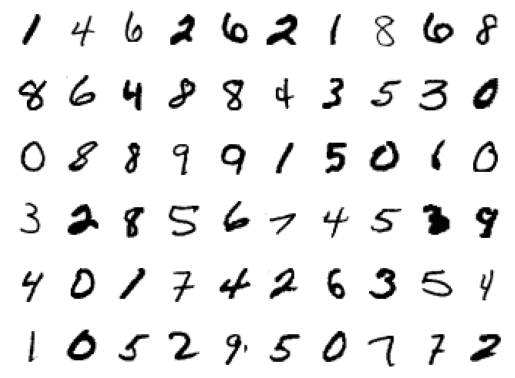

In [10]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')


![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*HWhBextdDSkxYvz0kEMTVg.png)

In [11]:
input_size = 784 # 28x28 - Flattening the image
hidden_sizes = [128, 64]
output_size = 10

loss_fn = nn.CrossEntropyLoss() # Define the loss

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size))
print(model)
untrained_model = deepcopy(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)


**Note**: In Pytorch, nn.CrossEntropyLoss() computes softmax internally, so we don't need to apply softmax to the output layer.

nn.CrossEntropyLoss() is equivalent to nn.LogSoftmax() + nn.NLLLoss().

In [12]:
summary(model, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
              ReLU-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 64]           8,256
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


Epoch 0 - Train loss: 0.6535548080571031 - Train Accuracy: 81.82222222222222 - Val Accuracy: 90.16666666666667
Epoch 1 - Train loss: 0.29603921314833853 - Train Accuracy: 91.27037037037037 - Val Accuracy: 92.63333333333334
Epoch 2 - Train loss: 0.23701330737797852 - Train Accuracy: 93.02037037037037 - Val Accuracy: 93.35
Epoch 3 - Train loss: 0.1912896981092073 - Train Accuracy: 94.38518518518518 - Val Accuracy: 94.76666666666667
Epoch 4 - Train loss: 0.1602123022339885 - Train Accuracy: 95.2925925925926 - Val Accuracy: 95.23333333333333
Epoch 5 - Train loss: 0.13819539724624058 - Train Accuracy: 95.92592592592592 - Val Accuracy: 95.8
Epoch 6 - Train loss: 0.1198176264771706 - Train Accuracy: 96.42222222222222 - Val Accuracy: 95.91666666666667
Epoch 7 - Train loss: 0.10418186883080167 - Train Accuracy: 96.98148148148148 - Val Accuracy: 96.33333333333333
Epoch 8 - Train loss: 0.0937929259683778 - Train Accuracy: 97.23703703703704 - Val Accuracy: 96.43333333333334
Epoch 9 - Train loss: 0

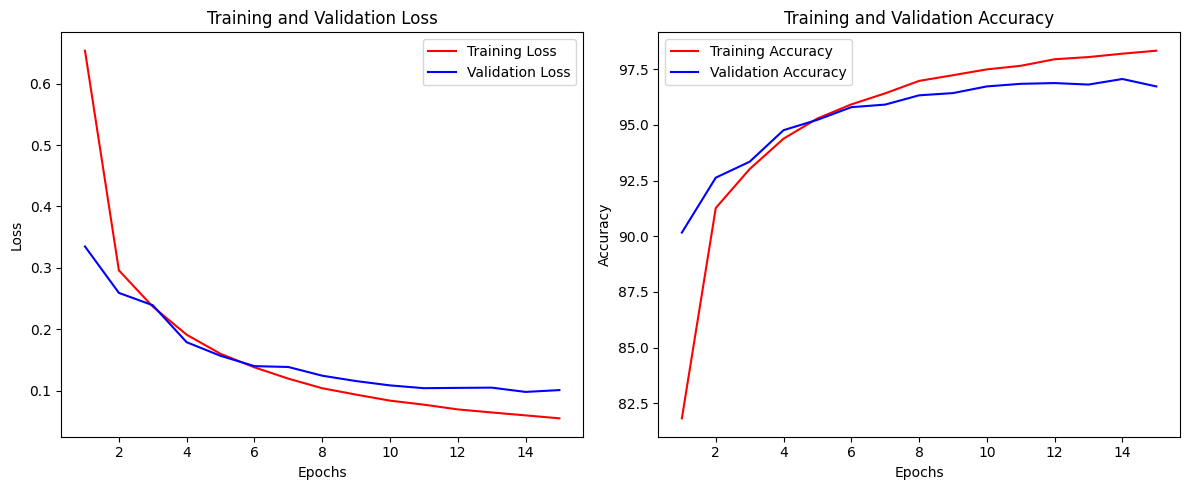

Test Accuracy: 97.18, Test Loss: 0.08713187636906922


In [13]:
performance_tracker = PerformanceTracker()
train_model(performance_tracker, model, loss_fn, train_loader, val_loader, epochs=15, lr=0.003, flatten=True)
test_acc, test_loss = test_model(model, loss_fn, test_loader, flatten=True)
mnist_results['LinearModel'] = {'test_acc': test_acc, 'test_loss': test_loss}

Predicted Digit = 8


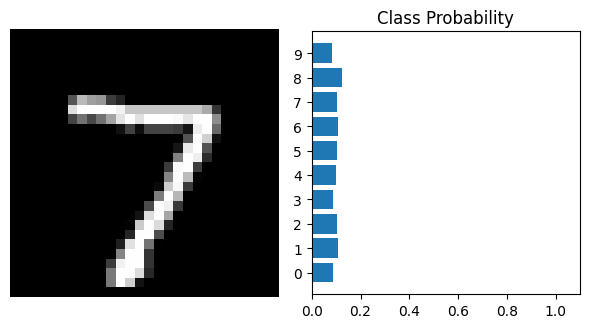

In [14]:
images, labels = next(iter(test_loader))

img = images[0].view(1, 784)

with torch.no_grad():
    logps = untrained_model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

Predicted Digit = 7


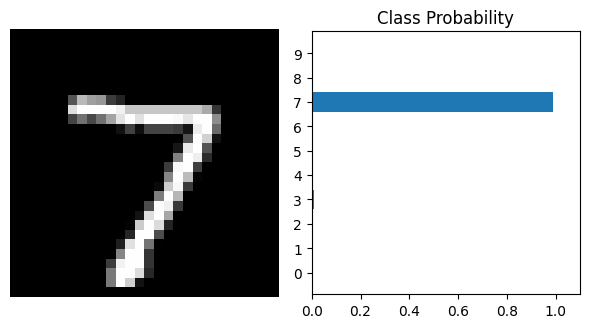

In [15]:


with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), logps)

---

# Using the Visual Patterns in the Images

When flattening the images, we lose the spatial and structural information. To capture the spatial and structural information, we can use Convolutional Neural Networks (CNNs). CNNs learn to recognize complex patterns by building hierarchies of simpler patterns. The first layers might capture basic features like edges and corners, intermediate layers combine these into more complex structures (e.g., circles, stripes), and deeper layers may identify high-level features (e.g., faces, objects). For MNIST, this means that the network can learn to recognize the distinctive shapes and curves of each digit.

![CNN](https://miro.medium.com/v2/resize:fit:1162/format:webp/1*HxYdjdOD9xdjDPzGM313Fg.jpeg)

In [16]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,  # since the images are grayscale, the number of input channels is 1            
                out_channels=3,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(3, 6, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(6 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

cnn_model = CNN()
summary(cnn_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              78
              ReLU-2            [-1, 3, 28, 28]               0
         MaxPool2d-3            [-1, 3, 14, 14]               0
            Conv2d-4            [-1, 6, 14, 14]             456
              ReLU-5            [-1, 6, 14, 14]               0
         MaxPool2d-6              [-1, 6, 7, 7]               0
            Linear-7                   [-1, 10]           2,950
Total params: 3,484
Trainable params: 3,484
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.01
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


Epoch 0 - Train loss: 0.5324164481913026 - Train Accuracy: 82.99259259259259 - Val Accuracy: 95.21666666666667
Epoch 1 - Train loss: 0.1305018530670836 - Train Accuracy: 96.03518518518518 - Val Accuracy: 96.11666666666666
Epoch 2 - Train loss: 0.09948774341215773 - Train Accuracy: 96.92777777777778 - Val Accuracy: 97.2
Epoch 3 - Train loss: 0.08671906341244666 - Train Accuracy: 97.26481481481481 - Val Accuracy: 97.18333333333334
Epoch 4 - Train loss: 0.07722015286105027 - Train Accuracy: 97.56851851851852 - Val Accuracy: 97.6
Epoch 5 - Train loss: 0.07130038156974133 - Train Accuracy: 97.76481481481481 - Val Accuracy: 97.5
Epoch 6 - Train loss: 0.06665549196481652 - Train Accuracy: 97.89444444444445 - Val Accuracy: 97.41666666666667
Epoch 7 - Train loss: 0.06443897793063964 - Train Accuracy: 97.97037037037038 - Val Accuracy: 97.3
Epoch 8 - Train loss: 0.060216915712336526 - Train Accuracy: 98.11296296296297 - Val Accuracy: 97.88333333333334
Epoch 9 - Train loss: 0.058040279784996804 - 

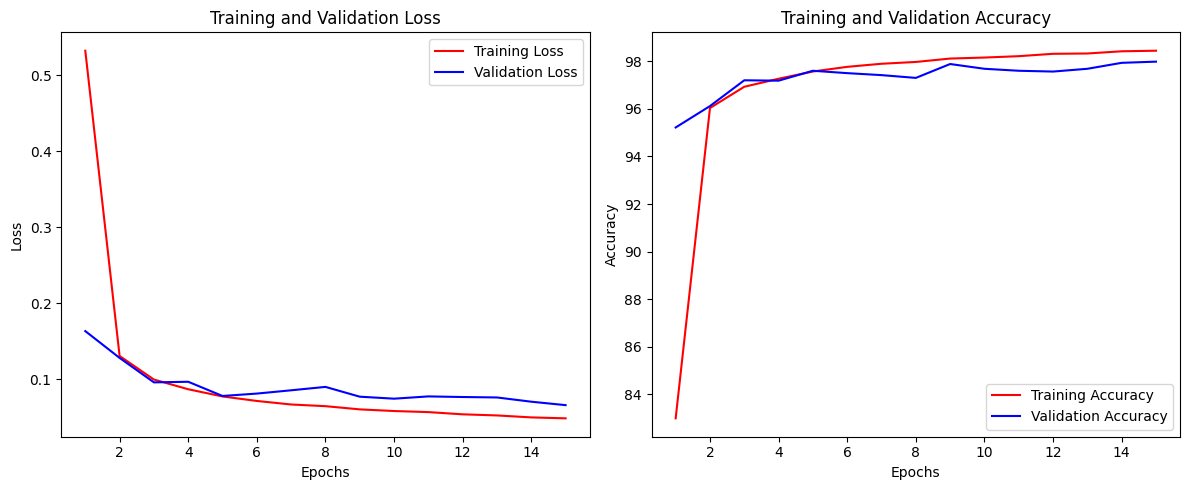

Test Accuracy: 98.22, Test Loss: 0.05276487150250276


In [17]:
performance_tracker = PerformanceTracker()
loss_fn = nn.CrossEntropyLoss() 
train_model(performance_tracker, cnn_model, loss_fn, train_loader, val_loader, epochs=15, lr=0.003, flatten=False)
test_acc, test_loss = test_model(cnn_model, loss_fn, test_loader, flatten=False)
mnist_results['CNNModel'] = {'test_acc': test_acc, 'test_loss': test_loss}

In [18]:
tabulate_results(mnist_results)

+-------------+----------+---------------------+
|    Model    | test_acc |      test_loss      |
+-------------+----------+---------------------+
| LinearModel |  97.18   | 0.08713187636906922 |
|  CNNModel   |  98.22   | 0.05276487150250276 |
+-------------+----------+---------------------+


#### Note: 
Even though the accuracies are not that different for MNIST, CNNs are much better at capturing the spatial and structural information in the images (you will see this while working with more complex datasets like cifar100, imagenet, etc). From the above table, you can see that the test_loss is much lower for CNNs than for MLPs. Indicating much more confident predictions.

---

# NLP - Getting Text Ready for Neural Networks

## Download the dataset

In [19]:
import requests
import tarfile
from io import BytesIO

# URL to download the dataset
url = 'https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz'

# Make a request to get the dataset
response = requests.get(url)
if response.status_code == 200:
    # Open the downloaded dataset as a tar file
    file_obj = BytesIO(response.content)
    tar = tarfile.open(fileobj=file_obj, mode="r:gz")
    
    # Specify the path where to extract the files
    extract_path = './data/rt-polaritydata'
    
    # Extract the dataset
    tar.extractall(path=extract_path)
    tar.close()
    
    # Success message
    "The dataset has been successfully downloaded and extracted."
else:
    # Error message
    "Failed to download the dataset. Please check the URL or your internet connection."


In [20]:
def load_text(path):
    """Load text data, lowercase text and save to a list."""

    with open(path, 'rb') as f:
        texts = []
        for line in f:
            texts.append(line.decode(errors='ignore').lower().strip())

    return texts

# Load files
neg_text = load_text('data/rt-polaritydata/rt-polaritydata/rt-polarity.neg')
pos_text = load_text('data/rt-polaritydata/rt-polaritydata/rt-polarity.pos')

# Concatenate and label data
texts = np.array(neg_text + pos_text)
labels = np.array([0]*len(neg_text) + [1]*len(pos_text))

In [21]:
print('Negative review:', texts[0])
print('Positive review:', texts[-1])

Negative review: simplistic , silly and tedious .
Positive review: provides a porthole into that noble , trembling incoherence that defines us all .


## Download Pretrained Word Vectors

In [22]:
import os
import zipfile
import requests

# Define the URL and the target directory
url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
file_dir = "./data/fastText"  # Using /mnt/data for persistent storage in this environment
file_path = os.path.join(file_dir, "crawl-300d-2M.vec.zip")

# Check if the directory already exists
if not os.path.isdir(file_dir):
    os.makedirs(file_dir)
    print("Directory created.")
else:
    print("Directory already exists.")

# Function to download and extract the file
def download_and_extract(url, file_path, file_dir):
    # Download the file
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_path, "wb") as f:
            f.write(response.content)
        print("Download completed.")

        # Extract the file
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(file_dir)
        print("Extraction completed.")
    else:
        print("Failed to download the file. Please check the URL or your internet connection.")

# Call the function if the zip file doesn't exist
if not os.path.exists(file_path):
    download_and_extract(url, file_path, file_dir)
else:
    print("File already downloaded.")


Directory already exists.
File already downloaded.


## Preparing Text for Deep Learning Models

We first need to ``tokenize`` the text, i.e. split the text into words and then convert the words into integers (ids). The process of converting text into a sequence of tokens is called tokenization. Then, we need to assign each token to a number, which we can then feed into a neural network    

For this, we build a vocabulary dictionary ``word2idx`` that maps each word to a unique integer. We also build a reverse vocabulary dictionary ``idx2word`` that maps each integer to its corresponding word (Used in text generation, which converts the ids generated by the Model back to words). ``word2idx`` would be used to convert our tokens into indexes and build an embedding layer.

* Step 1: Tokenization    

    Tokenization is the process of converting text into a sequence of tokens (words or subwords). It's the first step in text preprocessing for neural networks.    
    The text is split into individual components based on spaces and punctuation. For example, the sentence "Hello, world!" would be split into ["Hello", ",", "world", "!"].    

* Step 2: Convert Tokens to Integers (Token ids)    

    After tokenization, each token needs to be represented in a form that a neural network can understand, which is numerical.
    Each unique token is assigned a unique integer. This is crucial for creating a numerical representation of the text data. 
    Example: If your corpus contains the tokens ["Hello", ",", "world", "!"], you might assign the integers [2, 3, 4, 5] to these tokens.

    word2idx is a dictionary that maps each unique word in your corpus to a unique integer. This mapping facilitates the conversion of text tokens into numerical indices.    
    Example: If your corpus contains the tokens ["Hello", ",", "world", "!"], word2idx would be {"Hello": 2, ",": 3, "world": 4, "!": 5}. 

    idx2word is the inverse of word2idx, mapping integers back to their corresponding words. This is useful for interpretation and debugging.
    Example: Using the word2idx example above, idx2word would be {2: "Hello", 3: ",", 4: "world", 5: "!"}. So that when the model generates the ids, we can convert them back to words.

* Step 3: Convert Token ids to Word Vectors    

    After tokenization and conversion to integers, each token is represented as a unique integer. This integer can then be used to index into a word vector (Embedding Layer), which becomes the numerical representation of that word that goes into Deep Learning Models. We can assign token ids with the corresponding word vectors from pretrained word vectors. These pretrained word vectors inherently capture the semantic meaning of the words, and are thus a good starting point for the word vectors in our model.

## Using Pretrained Word Vectors

We can use pretrained word vectors to initialize the word embedding layer in our model. These pretrained word vectors are trained on large corpora and capture the semantic meaning of the words. We can use these pretrained word vectors as the initial word vectors in our embedding layer in the model, and then fine-tune them during training.

What does "semantic" mean in the context of word vectors?

When we say that an embedding layer captures the semantic meaning of words, it means that the layer learns to represent words in a high-dimensional space in such a way that the geometric relationships between these word vectors reflect the actual relationships between the words in language.

For example:

- Similarity: Words with similar meanings are positioned closer together in the embedding space. For instance, "happy" and "joyful" would have vectors that are close to each other.

- Relationships: The embeddings can capture more complex relationships beyond simple similarity, such as analogies. A famous example is the vector arithmetic property found in some embeddings, where the relationship "king - man + woman = queen" can be approximately demonstrated through the respective word vectors.

- Context: In more advanced models, embeddings can capture contextual meanings, meaning that the representation of a word can change based on the other words in the sentence, allowing the model to distinguish between the different meanings of a word used in different contexts (e.g., "bank" in "river bank" vs. "savings bank").

These inductive biases are useful for the model to learn from the data more efficiently, and they can be especially helpful when the training data is limited.

## Embedding Layer?

An Embedding layer will serve as a look-up table which takes words’ indexes in the vocabulary as input and output word vectors. Hence, the embedding layer has shape (N, d) where N is the number of unique words in the vocabulary (size of the vocabulary) and d is the dimension of the word vectors (embedding dimension).

## Training the Embedding Layer?

We can also train this look-up table. In order to train our embedding layer, we create the embedding layer in our ``nn.module`` model class. The input to our model would be the indexes of the words in the vocabulary. 

``nn.Embedding`` is – just like a linear layer – a M x N matrix, with M being the number of words and N being the size of each word vector. It just matches a word (specified by an index) to the corresponding word vector, i.e., the corresponding row in the matrix. ([Reference](https://discuss.pytorch.org/t/how-does-nn-embedding-work/88518/8))

The function ``tokenize`` will tokenize our sentences, builds a vocabulary and finds the maximum sentence length. The function ``encode`` will take outputs of tokenize as inputs, performs sentence padding and returns input_ids as a numpy array.

In [23]:

from collections import defaultdict

def tokenize(texts):
    """Tokenize texts, build vocabulary and find maximum sentence length.
    
    Args:
        texts (List[str]): List of text data
    
    Returns:
        tokenized_texts (List[List[str]]): List of list of tokens
        word2idx (Dict): Vocabulary built from the corpus
        max_len (int): Maximum sentence length
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_texts.append(tokenized_sent)

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

def encode(tokenized_texts, word2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will the input of our model.
    """

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

## Example:

In [24]:
from nltk.tokenize import word_tokenize

example_texts = ["Hello world!", "Hello, this is a sample sentence."]

example_tokenized_texts, example_word2idx, example_max_len = tokenize(example_texts)

print("Tokenized Texts:", example_tokenized_texts)
print("Vocabulary:", example_word2idx)
print("Maximum Sentence Length:", example_max_len)

Tokenized Texts: [['Hello', 'world', '!'], ['Hello', ',', 'this', 'is', 'a', 'sample', 'sentence', '.']]
Vocabulary: {'<pad>': 0, '<unk>': 1, 'Hello': 2, 'world': 3, '!': 4, ',': 5, 'this': 6, 'is': 7, 'a': 8, 'sample': 9, 'sentence': 10, '.': 11}
Maximum Sentence Length: 8


In [25]:
example_input_ids = encode(example_tokenized_texts, example_word2idx, example_max_len)

for example_idx, example_text in enumerate(example_texts):
    print(f"Text: {example_text}")
    print(f"Token IDs: {example_input_ids[example_idx]}")
    print()

Text: Hello world!
Token IDs: [2 3 4 0 0 0 0 0]

Text: Hello, this is a sample sentence.
Token IDs: [ 2  5  6  7  8  9 10 11]



## Next step: Convert Token ids to vectors

In [26]:
from tqdm import tqdm_notebook
from nltk.tokenize import word_tokenize

def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0] # The first token is the word itself, the rest are the values of the embedding
        if word in word2idx: # Update the embedding if the word is in our vocabulary
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)


    return embeddings

In [27]:
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)

# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, "data/fastText/crawl-300d-2M.vec")
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


/var/folders/8m/_7tr45rs7cv09g0b7cyt4t8w0000gn/T/ipykernel_2710/2496761641.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin):


0it [00:00, ?it/s]

In [28]:
print(embeddings.shape)
print(embeddings[word2idx['good']].shape)


torch.Size([20280, 300])
torch.Size([300])


In [29]:
def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Specify batch_size
    batch_size = 50

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_dataloader = DataLoader(train_data, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_dataloader = DataLoader(val_data,  batch_size=batch_size)

    return train_dataloader, val_dataloader

In [30]:
from sklearn.model_selection import train_test_split

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.1, random_state=42)

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = \
data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=50)

## Defining the Model

In [31]:
class MLP_NLP(nn.Module):
    """A Multilayer Perceptron Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 hidden_sizes=[100, 100],  # Example hidden sizes
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for MLP_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim).
            freeze_embedding (bool): Set to True to prevent the pretrained
                embeddings from being updated during training. Default: False.
            vocab_size (int): Need to be specified when pretrained embeddings
                are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained embeddings are not used. Default: 300.
            hidden_sizes (List[int]): List of hidden layer sizes. Each element
                represents a layer. Default: [100, 100].
            num_classes (int): Number of classes. Default: 2.
            dropout (float): Dropout rate. Default: 0.5.
        """
        
        super(MLP_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.vocab_size = vocab_size
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
                                          
        # MLP Network
        self.hidden_layers = nn.ModuleList()
        # input_size = embed_dim  # Assuming we're flattening the embedded input
        input_size = 18600
        print(input_size)
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(input_size, hidden_size))
            input_size = hidden_size
        
        # Output layer
        self.output_layer = nn.Linear(input_size, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids):
        """
        Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                num_classes)
        """
        
        # Embedding layer
        # Output shape: (batch_size, max_sent_length, embed_dim)
        x_embed = self.embedding(input_ids).float()
        
        # Flatten the embeddings
        # New shape: (batch_size, max_sent_length * embed_dim)
        x_flat = x_embed.view(x_embed.size(0), -1)
        
        # Pass through hidden layers
        x = x_flat
        for layer in self.hidden_layers:
            x = nn.functional.relu(layer(x))
            x = self.dropout(x)  # Apply dropout
        
        # Output layer
        logits = self.output_layer(x)
        
        return logits

In [32]:
def initilize_mlp_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    dropout=0.5,
                    learning_rate=0.01):

    mlp_model = MLP_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        hidden_sizes=[100, 100],
                        num_classes=2,
                        dropout=0.5)

    # Instantiate Adadelta optimizer
    optimizer = optim.AdamW(mlp_model.parameters(),
                            lr=learning_rate,
                            weight_decay=0.001)

    return mlp_model, optimizer

## Training the Model

In [33]:
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    
    # Tracking best validation accuracy
    best_accuracy = 0

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9} | {'current_lr':^9}")
    print("-"*70)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            b_input_ids, b_labels = tuple(t for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Update the learning rate
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f} | {current_lr:^9.2e}")

            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

## MLP-rand: Word vectors are randomly initialized.

We start with a random embedding layer (No Prior Knowledge on the semantic meaning of words) and then train it using backpropagation. The embedding layer will be updated during the training process to minimize the loss function.

In [34]:
set_seed(42)
mlp_rand, optimizer = initilize_mlp_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=1e-5,
                                    dropout=0.5)
train(mlp_rand, optimizer, train_dataloader, val_dataloader, epochs=30)

18600
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed  | current_lr
----------------------------------------------------------------------
   1    |   0.697644   |  0.694213  |   51.14   |   2.48    | 9.97e-06 
   2    |   0.693859   |  0.693187  |   51.14   |   2.45    | 9.89e-06 
   3    |   0.691117   |  0.692222  |   51.14   |   2.40    | 9.76e-06 
   4    |   0.688671   |  0.691353  |   51.23   |   2.42    | 9.57e-06 
   5    |   0.685685   |  0.690389  |   51.50   |   2.44    | 9.33e-06 
   6    |   0.682578   |  0.689447  |   52.23   |   2.44    | 9.05e-06 
   7    |   0.678279   |  0.688407  |   52.04   |   2.51    | 8.72e-06 
   8    |   0.673922   |  0.687215  |   53.13   |   2.44    | 8.35e-06 
   9    |   0.670480   |  0.685943  |   54.50   |   2.43    | 7.94e-06 
  10    |   0.664692   |  0.684664  |   56.48   |   2.44    | 7.50e-06 
  11    |   0.658636   |  0.683357  |   57.39   |   2.45    | 7.03e-06 
  12    |   0.654407   |  0.681990  |  

## MLP-static: fastText pretrained word vectors are used and freezed during training.

We can add prior knowledge to our model by using pre-trained word vectors. These pre-trained word vectors are trained on a large corpus of text and capture the semantic meaning of words, and relationships between words. We can use these pre-trained word vectors as our embedding layer and freeze them during training. This means that the word vectors will not be updated during the training process.

In [35]:
set_seed(42)
mlp_static, optimizer = initilize_mlp_model(pretrained_embedding=embeddings,
                                        freeze_embedding=True,
                                        learning_rate=1e-5,
                                        dropout=0.5)
train(mlp_static, optimizer, train_dataloader, val_dataloader, epochs=30)

18600
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed  | current_lr
----------------------------------------------------------------------
   1    |   0.693423   |  0.691379  |   51.14   |   0.94    | 9.97e-06 
   2    |   0.690583   |  0.688858  |   51.14   |   0.92    | 9.89e-06 
   3    |   0.686421   |  0.684727  |   52.87   |   0.98    | 9.76e-06 
   4    |   0.680056   |  0.678506  |   57.68   |   0.97    | 9.57e-06 
   5    |   0.672541   |  0.670467  |   63.03   |   0.94    | 9.33e-06 
   6    |   0.663385   |  0.661348  |   67.67   |   0.93    | 9.05e-06 
   7    |   0.650537   |  0.650715  |   70.20   |   0.97    | 8.72e-06 
   8    |   0.635798   |  0.639263  |   71.29   |   0.99    | 8.35e-06 
   9    |   0.623409   |  0.627881  |   72.38   |   0.92    | 7.94e-06 
  10    |   0.607779   |  0.616462  |   72.56   |   0.91    | 7.50e-06 
  11    |   0.594398   |  0.605819  |   73.57   |   0.94    | 7.03e-06 
  12    |   0.580030   |  0.595876  |  

## MLP-non-static: fastText pretrained word vectors are fine-tuned during training.

We can also fine-tune the pre-trained word vectors during the training process. This means that the word vectors will be updated during the training process to minimize the loss function.

In [36]:
# MLP-non-static: fastText pretrained word vectors are fine-tuned during training.
set_seed(42)
mlp_non_static, optimizer = initilize_mlp_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=1e-5,
                                            dropout=0.5)
train(mlp_non_static, optimizer, train_dataloader, val_dataloader, epochs=30)

18600
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed  | current_lr
----------------------------------------------------------------------
   1    |   0.693422   |  0.691364  |   51.14   |   3.91    | 9.97e-06 
   2    |   0.690545   |  0.688799  |   51.14   |   3.98    | 9.89e-06 
   3    |   0.686271   |  0.684525  |   53.41   |   3.59    | 9.76e-06 
   4    |   0.679614   |  0.677980  |   58.04   |   3.60    | 9.57e-06 
   5    |   0.671530   |  0.669215  |   64.40   |   3.60    | 9.33e-06 
   6    |   0.661588   |  0.659171  |   68.76   |   3.59    | 9.05e-06 
   7    |   0.647302   |  0.647135  |   70.57   |   3.66    | 8.72e-06 
   8    |   0.630862   |  0.634056  |   71.83   |   3.63    | 8.35e-06 
   9    |   0.616558   |  0.620939  |   73.20   |   3.67    | 7.94e-06 
  10    |   0.598552   |  0.607669  |   73.74   |   3.74    | 7.50e-06 
  11    |   0.583036   |  0.595344  |   74.02   |   3.74    | 7.03e-06 
  12    |   0.566307   |  0.583762  |  

In [37]:
def predict(text, model=mlp_non_static, max_len=62):
    """Predict probability that a review is positive."""

    # Tokenize, pad and encode text
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = nn.functional.softmax(logits, dim=1).squeeze(dim=0)

    print(f"This review is {probs[1] * 100:.2f}% positive.")

In [46]:
predict("I loved the movie!!")
predict("What a waste of time")
predict("All of friends slept while watching this movie. But I really enjoyed it.")
predict("This movie is lway too long and boring.")
predict("I don't like the ending. It's not good.")

This review is 57.81% positive.
This review is 33.48% positive.
This review is 48.55% positive.
This review is 27.41% positive.
This review is 30.83% positive.


---

# References
* https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627
* https://chriskhanhtran.github.io/posts/cnn-sentence-classification/